# Hypothesis Testing

Python notebook for illustrating the concept of Hypothesis Testing and specific test statistics; among them the very useful Kolmogorov-Smirnov test.

The Kolmogorov-Smirnov test (KS test) is a general test to evaluate if two distributions in 1D are the same. This program applies three hypothesis tests to determine, if two distributions are the same:
1. A simple comparison of means.
2. A $\chi^2$-test between histograms.
3. An unbinned KS test

The distributions compared are two unit Gaussians (A and B), where one is then modified by changing:
- Mean
- Width
- Normalisation

The sensitivity of each test is then considered for each of these changes.

### References:
- Barlow: p. 155-156
- __[Wikipedia: Kolmogorov-Smirnov test](http://en.wikipedia.org/wiki/Kolmogorov-Smirnov_test)__
- Though influenced by biostatistics, a good discussion of p-values and their distribution can be found here:
  [How to interpret a p-value histogram?](http://varianceexplained.org/statistics/interpreting-pvalue-histogram/)

### Authors: 
Troels C. Petersen (Niels Bohr Institute)

### Date:    
07-12-2023 (latest update)

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy.special import erfc
from scipy import stats


Set the parameters of the plot:

In [2]:
r = np.random             # Random generator
r.seed(42)                # Set a random seed (but a fixed one)

save_plots = False
verbose = True

The small function below is just a simple helper function that takes a 1D-array input along with an axis, position and color arguments and plot the number of entries, the mean and the standard deviation on the axis:

In [3]:
def ax_text(x, ax, posx, posy, color='k'):
    d = {'Entries': len(x), 
         'Mean': x.mean(),
         'STD': x.std(ddof=1),
        }    
    add_text_to_ax(posx, posy, nice_string_output(d), ax, fontsize=12, color=color)
    return None

and finally a function that calculates the mean, standard deviation and the standard deviation (i.e. uncertainty) on the mean (sdom):

In [4]:
def mean_std_sdom(x):
    std = np.std(x, ddof=1)
    return np.mean(x), std, std / np.sqrt(len(x))

## Set up the experiment:

How many experiments, and how many events in each:

In [5]:
N_exp = 1000
N_events_A = 100
N_events_B = 100

Define the two Gaussians to be generated (no difference to begin with!):

In [6]:
dist_mean_A  =  0.0
dist_width_A =  1.0
dist_mean_B  =  0.0
dist_width_B =  1.0

Define the number of bins and the range, initialize empty arrays to store the results in and make an empty figure (to be filled in later):

In [7]:
N_bins = 100
xmin, xmax = -5.0, 5.0

all_p_mean = np.zeros(N_exp)
all_p_chi2 = np.zeros(N_exp)
all_p_ks   = np.zeros(N_exp)

# Figure for the two distributions, A and B, in the first experiment:
fig1, ax1 = plt.subplots(figsize=(10, 6))
plt.close(fig1)

Loop over how many times we want to run the experiment, and for each calculate the p-value of the two distributions coming from the same underlying PDF (put in calculations yourself):

### Solution note on hypothesis testing using the means:

The solution implemented below is a great example of the core of hypothesis testing (see slide 27 of ["Hypothesis testing"](https://www.nbi.dk/~petersen/Teaching/Stat2021/Week4/AS2021_12_13_HypothesisTesting.pdf)).

<u>First we **state the hypothesis**:</u><br>
 - Null hypothesis: They are from the SAME underlying distribution, and so the means are the same.
 - Alternative hypothesis: They are from DIFFERENT underlying distributions, and so the means are different.

Now, remind yourself, that even if the means are the SAME, that is NOT a proof that the distributions are the same! We can not make such proofs - we can only reject hypothesis. But if the means are not consistent, then we can reject the null hypothesis that they are the same.

<u>Secondly, we **state the criteria for decision**:</u><br>
If the p-value for the two means to be the same is lower than 0.27% (3 sigma), then we reject the null hypothesis.

<u>Thirdly, we **compute the test statistic**:</u><br>
This will by most be considered the main part of the work. Well, first we compute the mean and their uncertainties for each of the two samples, and then we calculate the difference between the two means in terms of their uncertainty: $$z_c = (\mu_A - \mu_B) / \sqrt{\sigma(\mu_A)^2 + \sigma(\mu_B)^2}$$ 

Now, if the two distributions were statistically the same (null hypothesis), then we would expect this distribution to be **Unit Gaussian**, as it would simply be the result of statistical fluctuations away from zero. To calculate the p-value from $z_c$ we need to consider the probability of obtaining "this value or something more extreme". In this case, it is a two-sided test, since it is equally extreme for the mean of A to be (much) higher than the mean B, than vice versa. Thus, for a given value of $z_c$, we integrate both tails of the Unit Gaussian, and obtain the p-value ($p = c+c$), as illustrated in the figure below. Note how a value of $z_c$ close to zero leads to a p-value close to 1, while a $z_c$ value far from zero leads to a small p-value, as it should.

<u>Finally, we **take a decision** based on the above criteria and calculated p-value:</u><br>
This is easy: If the p-value is below the stated criteria, we reject the null hypothesis, and otherwise we do not!


<img src="GaussianForTwoSidedTest.jpg" alt="" style="width: 600px;"/>

Gaussian distribution (expected from null hypothesis) with calculation of p-values from a two-sided test. The test in the case at hand is two-sided, as it does not matter if mean(A) is greater or smaller than mean(B).

   0:  p_mean: 0.76433   p_chi2: 0.30643   p_ks: 0.70206
   1:  p_mean: 0.67378   p_chi2: 0.23861   p_ks: 0.70206
   2:  p_mean: 0.83420   p_chi2: 0.24279   p_ks: 0.70206
   3:  p_mean: 0.13627   p_chi2: 0.48332   p_ks: 0.36819
   4:  p_mean: 0.71622   p_chi2: 0.22451   p_ks: 0.28194
   5:  p_mean: 0.56416   p_chi2: 0.77413   p_ks: 0.90841
   6:  p_mean: 0.01184   p_chi2: 0.75203   p_ks: 0.03638
   7:  p_mean: 0.44734   p_chi2: 0.69438   p_ks: 0.90841
   8:  p_mean: 0.33001   p_chi2: 0.49301   p_ks: 0.28194
   9:  p_mean: 0.50714   p_chi2: 0.15720   p_ks: 0.90841
Got to experiment number: 1000


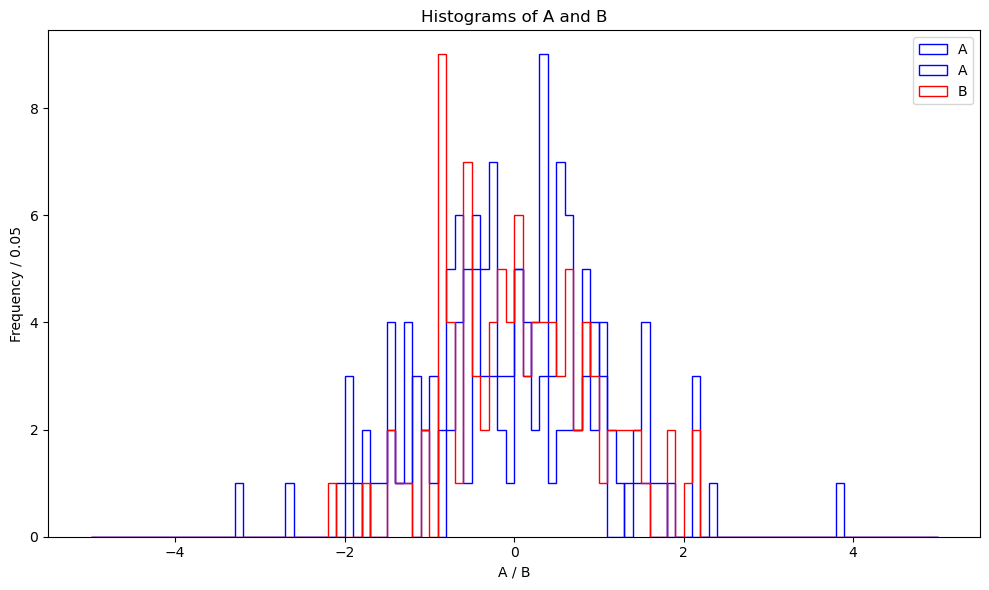

In [9]:
for iexp in range(N_exp):
    if ((iexp+1)%1000 == 0):
        print(f"Got to experiment number: {iexp+1}")

    # Generate data:
    x_A_array = r.normal(dist_mean_A, dist_width_A, N_events_A)
    x_B_array = r.normal(dist_mean_B, dist_width_B, N_events_B)
    
    
    # Test if there is a difference in the mean:
    # ------------------------------------------
    # Calculate mean, standard deviation, and error on mean (sdom):
    mean_A, std_A, sdom_A = mean_std_sdom(x_A_array)
    mean_B, std_B, sdom_B = mean_std_sdom(x_B_array)

    # Consider the difference between means in terms of the uncertainty:
    d_mean = mean_A - mean_B
    z_mean = d_mean/np.sqrt(sdom_A**2+sdom_B**2)

    # To get from number of sigmas to a p-value, we ask what the chance is to get this or a more extreme value.
    # Since it doesn't matter which one is highest, this is a two sided test, and thus we:
    # Take absolute value of number of sigmas, integrate out (to get left c in figure above), and multiply by two!
    p_mean = 2.0*stats.norm.cdf(-np.abs(z_mean), loc=0, scale=1)
    all_p_mean[iexp] = p_mean
    
    # Test if there is a difference with the chi2:
    # --------------------------------------------
    # Chi2 Test (where data must be binned first):
    [bins_A,edges_A] = np.histogram(x_A_array, bins=N_bins, range=(xmin,xmax))
    [bins_B,edges_B] = np.histogram(x_B_array, bins=N_bins, range=(xmin,xmax))
    centres_common = edges_A[1:] + (edges_A[:-1]-edges_A[1:])/2      # Same for A and B
    mask  = (bins_A + bins_B)!=0           # Mask empty bins to avoid dividing through 0
    chi2  = np.sum(((bins_A[mask] - bins_B[mask]) / np.sqrt(bins_A[mask]+bins_B[mask]))**2)
    n_dof = len(bins_A[mask])            # There are no parameters as it is not a fit!
    p_chi2= stats.chi2.sf(chi2,n_dof)
    all_p_chi2[iexp] = p_chi2

    # Test if there is a difference with the Kolmogorov-Smirnov test on arrays (i.e. unbinned):
    # -----------------------------------------------------------------------------------------
    p_ks = stats.ks_2samp(x_A_array, x_B_array)[1]           # Fortunately, the K-S test is implemented in stats!
    all_p_ks[iexp] = p_ks


    # Print the results for the first 10 experiments
    if (verbose and iexp < 10) :
      print(f"{iexp:4d}:  p_mean: {p_mean:7.5f}   p_chi2: {p_chi2:7.5f}   p_ks: {p_ks:7.5f}")

    
    # In case one wants to plot the distribution for visual inspection:
    if (iexp == 0):
        
        ax1.hist(x_A_array, N_bins, (xmin, xmax), histtype='step', label='A', color='blue')
        ax1.set(title='Histograms of A and B', xlabel='A / B', ylabel='Frequency / 0.05')        
        #ax_text(x_A_array, ax1, 0.04, 0.95, 'blue')

        ax1.hist(x_B_array, N_bins, (xmin, xmax), histtype='step', label='B', color='red')
        #ax_text(x_B_array, ax1, 0.04, 0.75, 'red')
        
        ax1.legend()
        fig1.tight_layout()

        
fig1

## Show the distribution of hypothesis test p-values:

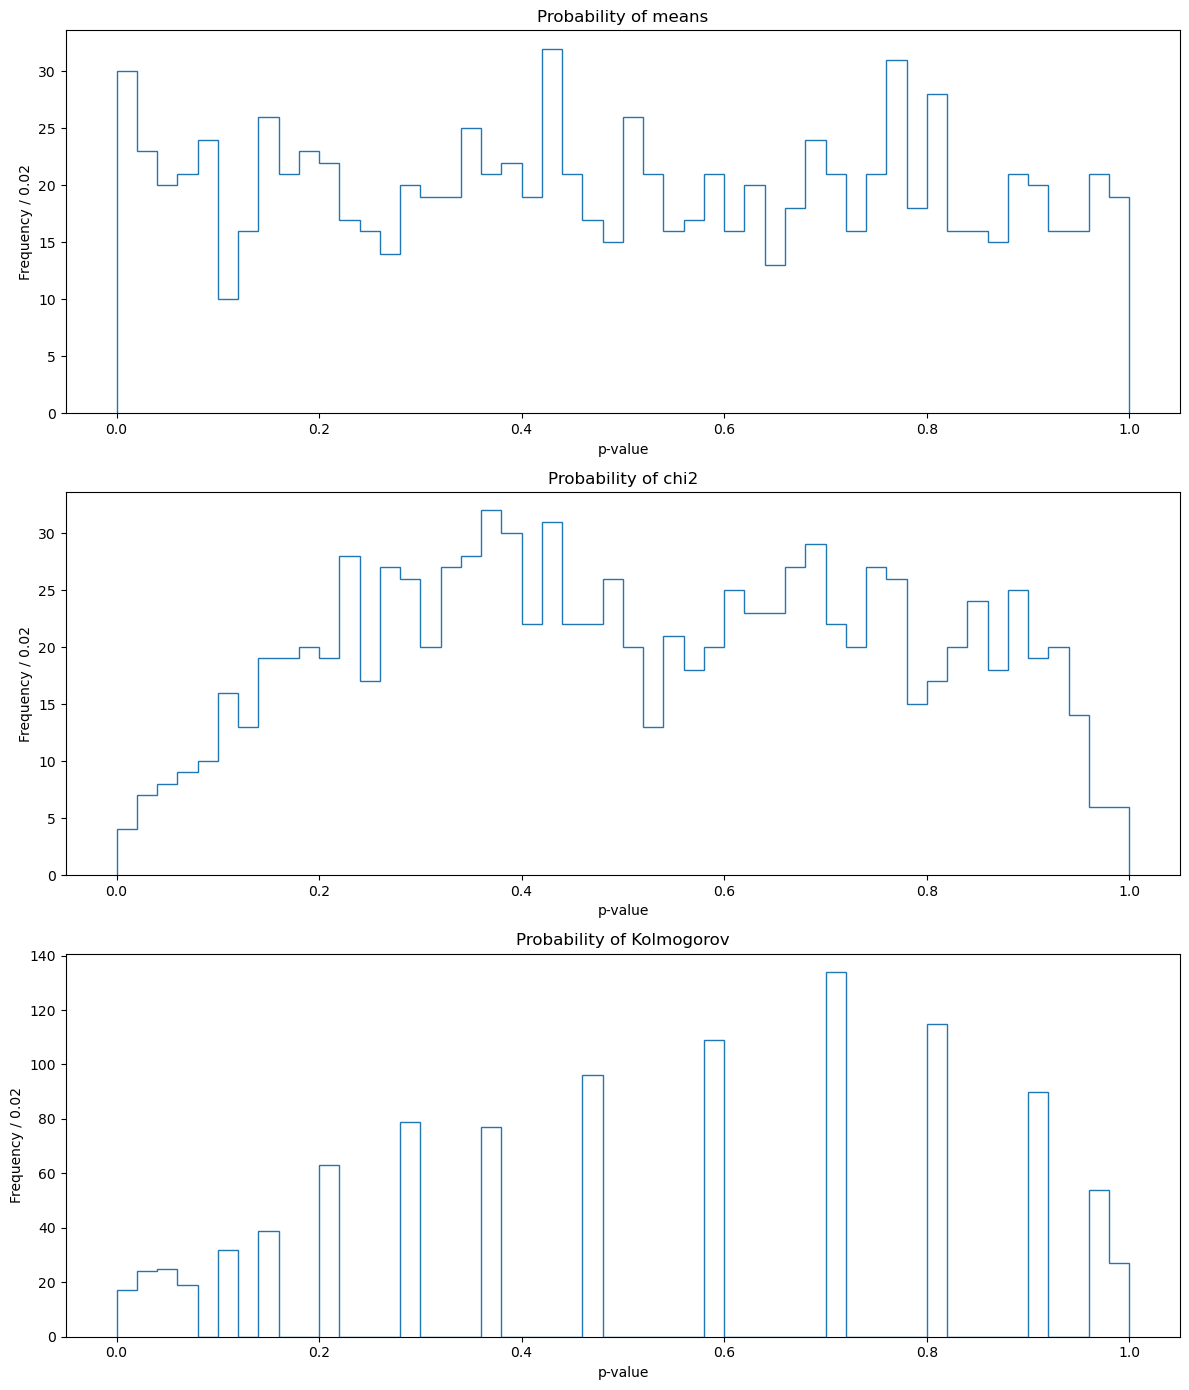

In [11]:
N_bins = 50

if (N_exp > 1):
    fig2, ax2 = plt.subplots(nrows=3, figsize=(12, 14))
    
    ax2[0].hist(all_p_mean, N_bins, (0, 1), histtype='step')
    ax2[0].set(title='Probability of means', xlabel='p-value', ylabel='Frequency / 0.02')
    #ax_text(all_p_mean, ax2[0], 0.04, 0.25)
    

    ax2[1].hist(all_p_chi2, N_bins, (0, 1), histtype='step')
    ax2[1].set(title='Probability of chi2', xlabel='p-value', ylabel='Frequency / 0.02')
    #ax_text(all_p_chi2, ax2[1], 0.04, 0.25)
    
    ax2[2].hist(all_p_ks, N_bins, (0, 1), histtype='step')
    ax2[2].set(title='Probability of Kolmogorov', xlabel='p-value', ylabel='Frequency / 0.02')
    #ax_text(all_p_ks, ax2[2], 0.04, 0.25)

    fig2.tight_layout()


    if save_plots:
        fig2.savefig('PvalueDists.pdf', dpi=600)

# Questions:

1. First run the program with one experiment (N_exp = 1) to display the two distributions A and B, when:
    - They are the same.
    - The mean of A is increased (to e.g. 0.1).
    - The width of A is enlarged (to e.g. 1.2).
    - The normalisation of A is increased.

Get a feel for how much you need to change the distribution, before you can _by eye_ see that they are not the same. I.e. can you see any difference, if `mean_A` $= 0.1$? Or how about $0.2$? How do you quantify this and when do you start to doubt? And how about `width_A` $= 1.1$? Or $1.2$? Again, can you see it by eye? Finally, try to put $1050$ events into B. Is that visible? How about $1100$?<br>
When you have an idea about when you can see effects by eye, now check if you see an impact in the p-values?

*Example Solution to problem 1*:<br>
Looking at the figure while trying different shifts of mean(A), I don't feel comfortable claiming any difference, before I reach a mean of 0.35. As it turns out, the first example (given the seed 42) is rather "unlucky" in that most other cases are more clear cut. But around this value, I can by eye see a difference.

***

2. Could you for the test of the means have calculated how much of a change in the mean is needed for a difference to be statistically significant? Do so, and see if it somewhat matches you guess/estimate from above!

*Example Solution to problem 2*:<br>
The example was chocen to be simple. With 100 entries in each sample and a width of 1.0, the uncertainty on the mean becomes $\sigma_{\mu} = \sigma / \sqrt{N} = 0.1$, and so the combined uncertainty between the two samples is $\sigma_{\Delta \mu} = \sqrt{\sigma_{\mu(A)}^2 + \sigma_{\mu(B)}^2} = 0.14$. Thus, when the difference gets larger than 0.28, there is **on average** a two sigma difference. With my estimate above, it was a 2.5 sigma difference, when I believed that I tell the difference.

***


3. Now run the tests 1000 times, where A and B are unit Gaussians and thus identical. How should the distributions of the test probabilities come out? And is this the case, approximately? If not, think of reasons for this, and what could be a remedy. HINT: Large statistics is always easier!

*Example Solution to problem 3*:<br>
The **means test** come out flat - great.<br>
The **ChiSquare test** is almost flat, but lack values of low p-values. This is due to the low statistics, which renderes the ChiSquare an approximation, as the uncertainties are not Gaussian.<br>
The **Kolmogorov-Smirnov test** has only discrete values, though these are roughly evenly distributed. This is because there is only a small number of possible outcomes given the low statistics... one integral can be [0, 1, ... 9] different, but typically not much more, leaving only the probabilities of these outcomes for the KS-test.

Increasing the statistics of sample A and B to 10000 yields flat distributions for all three test, as they should.

***


4. Repeat the changes in question 1), and see which tests "reacts" most to these modifications. How much of a change in the mean is required for 95% of the tests (of each kind) to give a probability below 5%? How much is required for the width? And the norm?

*Example Solution to problem 4*:<br>
For changes in the mean, both the means test and the KS-test reacts "as fast as statistically possible", while the ChiSquare test is slower. When changing the width, the means test is "blind", while the KS-test reacts faster than the ChiSquare test. For changes in the number of entries (which typically doesn't require these tests, as one can simply compare the two numbers), only the ChiSquare test reacts.

***


5. Possibly try to test different distributions than the Gaussian one (e.g. exponential, uniform, etc.), and see how the tests performs.

*Example Solution to problem 5*:<br>
Here, one can also test the difference between different distributions, such as Gaussian against Chi-Square, Gumbel, Student t, Binomial, Poisson, etc. distributions.


NOTE: The Kolmogorov-Smirnov test has the great advantage that it can handle ANY distribution (even the Cauchy distribution - remind yourself of that one!). The reason is, that it doesn't care about any PDF, nor how far out an outlier is. It is just a matter of the difference in integrals between the two functions.


## Advanced:

6. Obviously, the test of the means is not sensitive the a change in the width. Make such a test yourself by calculating the widths and the uncertainty on the widths (or perhaps try the F-test!). Note that in a (unit) Gaussian the uncertainty on the width is of the same order as that of the means!


## Very advanced:
7. Implement in python the following tests:
     - Lilliefors test
     - Shapiro-Wilk test
     - Anderson-Darling test
     - Cramer-von-Mises test
     - Jarque-Bera test
     - Kuiper's test
     - Mann-Whitney-Wilcoxon test
     - Siegel-Tukey test
     
and quantify under various conditions and datasets the power of each and the correlation among them. Write it up, and send it to a statistics journal. :-)

# Learning points:

The exercise should give you a good idea about the process of hypothesis testing, namely that you calculate a p-value, which under the null hypothesis is uniformly distributed.

You should be aware that in this exercise, we "play Gods" and repeat a perfect experiment over and over, to see the changes in the p-value distribution, when we change one of the input distributions. However, when you have real data, you will only get a single p-value! And you should be in a position, where you trust (and have perhaps tested using simulation) that the p-value really is uniform for the null hypothesis, and thus points to something "non-null", if very low.

The three tests (means, chi2, and KS) are some of the very standard approaches, but there are certainly also others.